In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Net(nn.Module):
    '''
    Defining model.
    1. Try to use minimal number of convolutions, with less channels, in accordance with RF required
    2. Used Transition layer with MaxPool and Pointwise convolution
    3. Used GAP layer, instead of linear to get data to 1D. THEN used a fully connected
    4. Try to fit the model as close as possible to 99% without using BN, Dropouts, Augmentation.
    5. Added BN, Dropout(10%), Augmenatiions to finally freeze the model

    '''
    def __init__(self):
        super(Net, self).__init__()                                            
        # convolution block 1        
        self.conv_block_1 = nn.Sequential(              # Input      Output      LRF     GRF
        
            nn.Conv2d(1, 8, 3),                            # 28x28x1    28x28x32    3x3     3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.10),

            nn.Conv2d(8, 16, 3),                            # 28x28x1    28x28x32    3x3     3x3
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10)
        )

        # convolution block 2
        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),                           # 28x28x32   28x28x32    3x3     5x5
            nn.BatchNorm2d(32),
            nn.Dropout(0.10)

        )

        # transition block 1
        self.transition_1 = nn.Sequential(
            nn.Conv2d(in_channels= 32,out_channels= 16, kernel_size =1),                        # 28x28x32   28x28x16    3x3     7x7
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                                        # 28x28x16   14x14x16            14x14 ?            
        )
        
        # convolution block 3
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10), 

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(0.10)
           

        )
        # fully connected
        self.fc1 = nn.Linear(32,10)


    def forward(self, x):

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.transition_1(x)
        x = self.conv_block_3(x)
 
        # GAP 
        x = F.adaptive_avg_pool2d(x, (1, 1)) #  10x10x32  -> 1x1x32 (actually 11x11x32 before)

        # reshape using flatten
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc1(x) #1x1x32 -> 1x1x10

        x = x.view(-1, 10)

        return F.log_softmax(x)

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,168
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
          Dropout-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 16, 22, 22]             528
             ReLU-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:

# ----------------------------------------------------------------
#         Layer (type)               Output Shape         Param #    # Input      Output      LRF     GRF
# ================================================================
#             Conv2d-1            [-1, 8, 26, 26]              80     28x28x1     26x26x8    3x3      3x3
#               ReLU-2            [-1, 8, 26, 26]               0    
#        BatchNorm2d-3            [-1, 8, 26, 26]              16
#            Dropout-4            [-1, 8, 26, 26]               0     
#             Conv2d-5           [-1, 16, 24, 24]           1,168     26x26x8     24x24x16   3x3      5x5
#               ReLU-6           [-1, 16, 24, 24]               0
#        BatchNorm2d-7           [-1, 16, 24, 24]              32
#            Dropout-8           [-1, 16, 24, 24]               0
#             Conv2d-9           [-1, 32, 22, 22]           4,640     24x24x16    22x22x32   3x3      7x7
#              ReLU-10           [-1, 32, 22, 22]               0
#       BatchNorm2d-11           [-1, 32, 22, 22]              64
#           Dropout-12           [-1, 32, 22, 22]               0
#            Conv2d-13           [-1, 16, 22, 22]             528    22x22x32    22x22x16    3x3      7x7
#              ReLU-14           [-1, 16, 22, 22]               0
#         MaxPool2d-15           [-1, 16, 11, 11]               0                                     14x14
#            Conv2d-16             [-1, 16, 9, 9]           2,320    11x11x16    9x9x16      3x3      16x16
#              ReLU-17             [-1, 16, 9, 9]               0
#       BatchNorm2d-18             [-1, 16, 9, 9]              32
#           Dropout-19             [-1, 16, 9, 9]               0
#            Conv2d-20             [-1, 32, 7, 7]           4,640    9x9x16      7x7x32      3x3     18x18
#              ReLU-21             [-1, 32, 7, 7]               0

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        transforms.RandomCrop(28 , padding = 1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    model.train()
    pbar = tqdm(train_loader)
    per_batch_loss = []

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)          
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        per_batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
#        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    
    per_epoch_loss = sum(per_batch_loss)/len(per_batch_loss)
    per_epoch_accuracy = 100.*( correct / len(train_loader.dataset))
    
    return per_epoch_loss, per_epoch_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    return test_loss , 100. * correct / len(test_loader.dataset)


  0%|          | 0/469 [00:00<?, ?it/s]

============== EPOCH  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1011, Accuracy: 9717/10000 (97.17%)

============== EPOCH  1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9810/10000 (98.10%)

============== EPOCH  2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9867/10000 (98.67%)

============== EPOCH  3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9851/10000 (98.51%)

============== EPOCH  4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

============== EPOCH  5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

============== EPOCH  6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

============== EPOCH  7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9901/10000 (99.01%)

============== EPOCH  8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9919/10000 (99.19%)

============== EPOCH  9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9918/10000 (99.18%)

============== EPOCH  10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)

============== EPOCH  11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

============== EPOCH  12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

============== EPOCH  13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9924/10000 (99.24%)

============== EPOCH  14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

============== EPOCH  15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9929/10000 (99.29%)

============== EPOCH  16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

============== EPOCH  17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

============== EPOCH  18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

============== EPOCH  19


100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

[97.17, 98.1, 98.67, 98.51, 99.08, 99.05, 99.25, 99.01, 99.19, 99.18, 99.15, 99.31, 99.33, 99.24, 99.43, 99.29, 99.26, 99.39, 99.35, 99.34]


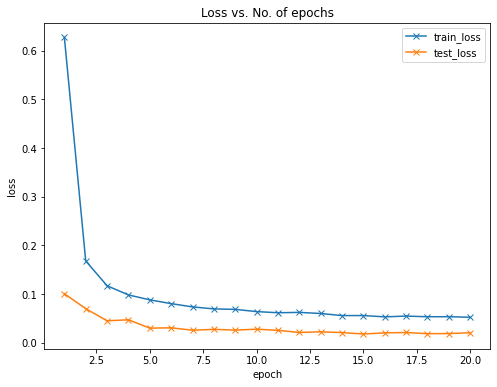

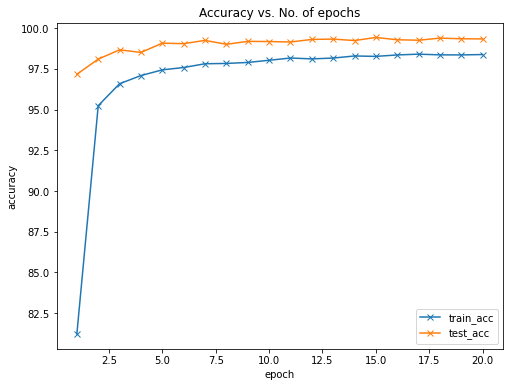

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.018, momentum=0.9)
loss_train = []
accuracy_train = []
loss_test = []
accuracy_test = []
epochs = 20
for epoch in range(0, epochs):
    print('============== EPOCH ', epoch)
    loss_train_epoch,accuracy_train_epoch = train(model, device, train_loader, optimizer, epoch)
    loss_test_epoch, accuracy_test_epoch = test(model, device, test_loader)
    
    
    loss_train.append(loss_train_epoch)
    accuracy_train.append(accuracy_train_epoch)

    loss_test.append(loss_test_epoch)
    accuracy_test.append(accuracy_test_epoch)


    

def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(1, epochs, epochs).astype(int),loss_train,'-x')
    plt.plot(np.linspace(1, epochs, epochs).astype(int),loss_test,'-x')
    plt.legend(['train_loss', 'test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')


def plot_accuracy(train_acc, test_acc):
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(1, epochs, epochs).astype(int),train_acc,'-x')
    plt.plot(np.linspace(1, epochs, epochs).astype(int),test_acc,'-x')
    plt.legend(['train_acc', 'test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_loss(loss_train,loss_test)
plot_accuracy(accuracy_train,accuracy_test)

print(accuracy_test)